Enable `Matplotlib` magic.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('image', origin='lower', interpolation='nearest')

Create `ipyparallel` clients. This also enables a few magic commands for parallel execution.
The documentation of `ipyparallel` is available [here](https://ipyparallel.readthedocs.io/en/latest/). How to setup `ipyparallel` to work with `MPI` is described [here](https://ipyparallel.readthedocs.io/en/latest/process.html#using-ipcluster-in-mpiexec-mpirun-mode).

In [2]:
from ipyparallel import Client
c = Client(profile="mpi")

Set parameters. The magic command `%%px` instructs `Jupyter` to run the entire cell on each client.

In [3]:
%%px

# Spatial resolution
nx, ny = 64, 64

# Average number of particles per cell
npc = 256

# Smoothed particle size in x/y direction
ax = 0.912871
ay = 0.912871

Initialize `PPIC2` and create coordinate arrays and density field.

In [4]:
%%px

from mpi4py.MPI import COMM_WORLD as comm
import numpy

from dtypes import Float
from fields import Field
from grid import Grid
from ppic2_wrapper import cppinit

# Start parallel processing.
idproc, nvp = cppinit(comm)

# Create numerical grid
grid = Grid(nx, ny, comm)

# Coordinate arrays
x = numpy.arange(grid.nx, dtype=Float)
y = grid.noff + numpy.arange(grid.nyp, dtype=Float)
xx, yy = numpy.meshgrid(x, y)

# Initialize density field
rho = Field(grid, comm, dtype=Float)
rho.fill(0.0)
ikx, iky = 1, 2
rho[:grid.nyp, :nx] = numpy.sin(2*numpy.pi*(ikx*xx/nx + iky*yy/ny))

Plot density field.

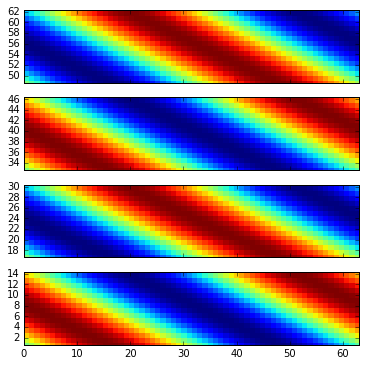

In [5]:
# Number of clients
nid = len(c.ids)

# Create figure
fig, axes = plt.subplots(nrows=nid, sharex=True, figsize=(6, 6))

# Global minimum and maximum of density field
vmin = min(c[:]['rho.trim().min()'])
vmax = max(c[:]['rho.trim().max()'])

# Loop over clients/processors
for v in c:

    # Axis ID. The order of subplots created by plt.subplots() is "reversed",
    # i.e. the upper-most subplot is axes[0] and the lower-most is axes[len(c.ids) - 1]
    iax = nid - 1 - v['idproc']

    # Local extent of the coordinate axes.
    extent=[v['x.min()'], v['x.max()'], v['y.min()'], v['y.max()']]

    # Plot density from each processor on the corresponding axis
    axes[iax].imshow(v['rho.trim()'], vmin=vmin, vmax=vmax, extent=extent)

Solve Gauss's law $\nabla\cdot E = \rho$

In [6]:
%%px

from dtypes import Float2
from poisson import Poisson

# Total number of particles
np = nx*ny*npc

# Initialize Poisson solver
poisson = Poisson(grid, ax, ay, np)

# Initialize force field
Exy = Field(grid, comm, dtype=Float2)
Exy.fill((0.0, 0.0))

# Solve Gauss' law
ttp, we = poisson(rho, Exy, destroy_input=False)

Plot x- and y-component of electric field.

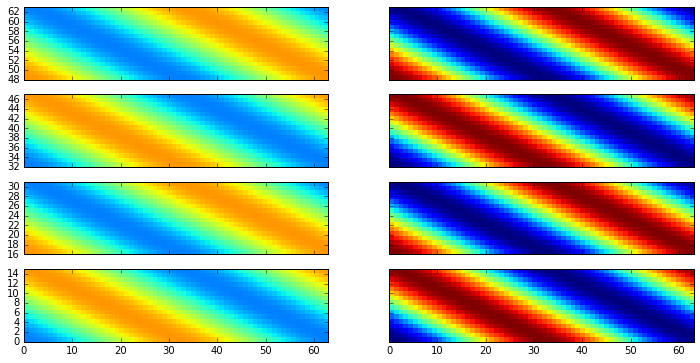

In [7]:
# Create figure
fig, axes = plt.subplots(nrows=nid, ncols=2, sharex=True, sharey="row", figsize=(12, 6))

# Global minimum and maximum of electric field (over all components)
vmin = min(c[:]['Exy["x"].trim().min()'] + c[:]['Exy["y"].trim().min()'])
vmax = max(c[:]['Exy["x"].trim().max()'] + c[:]['Exy["y"].trim().max()'])

# Loop over clients/processors
for v in c:

    # Axis ID. The order of subplots created by plt.subplots() is "reversed",
    # i.e. the upper-most subplot is axes[0] and the lower-most is axes[len(c.ids) - 1]
    iax = nid - 1 - v['idproc']

    # Local extent of the coordinate axes.
    extent=[v['x.min()'], v['x.max()'], v['y.min()'], v['y.max()']]

    # Plot electric field components from each processor on the corresponding axis
    axes[iax, 0].imshow(v['Exy["x"].trim()'], vmin=vmin, vmax=vmax, extent=extent)
    axes[iax, 1].imshow(v['Exy["y"].trim()'], vmin=vmin, vmax=vmax, extent=extent)